In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [9]:
df = pd.read_csv("data.csv")
df = df.sort_values(by="time")
df = df.dropna()
times = df["time"].unique()
values = [times[0]]

for time in times:
    add = True
    for value in values:
        if abs(value-time) < 100000:
            add = False
    if add:
        values.append(time)
        
print(f"Total number of packets: {len(values)} \n")
        
sizes = [i for i in range(1024, 65000, 9128)]

shapes = []
times = {}
function_calls = {}
total_times = []
sdap_total_calls = []

for module in df["module"].unique():
    times[module] = []
    function_calls[module] = []

for time, size in zip(values, sizes):
    df_temp = df[df["time"] >= time][df["time"] < time+50000]
    df_temp = df_temp.sort_values(by="time")
    shapes.append(df_temp[df_temp["timing"] == "start"].shape[0])
    sdap_calls = df_temp[df_temp["function"] == "sdap_data_req"][df_temp["timing"] == "start"].shape[0]
    sdap_total_calls.append(sdap_calls)
    end_time = df_temp["time"].max()
    total_time = df_temp["time"].max()-df_temp["time"].min()
    
    ## Create Temp Dict
    protocol_time = {}
    for module in df_temp["module"].unique():        
        calls = df_temp[df_temp["module"] == module][df_temp["timing"] == "start"].shape[0]
        function_calls[module].append(calls)
        protocol_time[module] = 0
    
    ## Calculate Times of Protocol based on "start" and "end" rows
    start = df_temp.reset_index()
    for ind in start.index[:-1]:
        curr_time = start["time"][ind]
        next_time = start["time"][ind+1]
        time = next_time - curr_time
        
        if start["timing"][ind+1] == "start":
            module = start["module"][ind+1]
        else:
            module = start["module"][ind+1]
            
        protocol_time[module] += time
    
    ## Add Times to Final Dict
    temp = 0 
    for i in protocol_time:
        temp += protocol_time[i]
        times[i].append(protocol_time[i])
    total_times.append(total_time)
    

Total number of packets: 8 



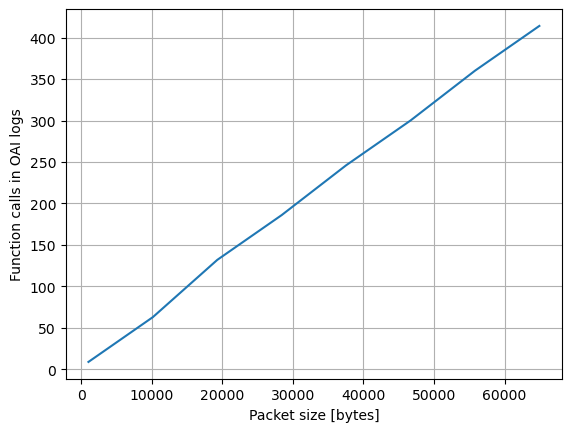

In [4]:
import matplotlib.pyplot as plt
plt.plot(sizes, shapes)
plt.grid()
plt.xlabel("Packet size [bytes]")
plt.ylabel("Function calls in OAI logs")
plt.savefig("large-packets_total-function-calls.png")
plt.show()

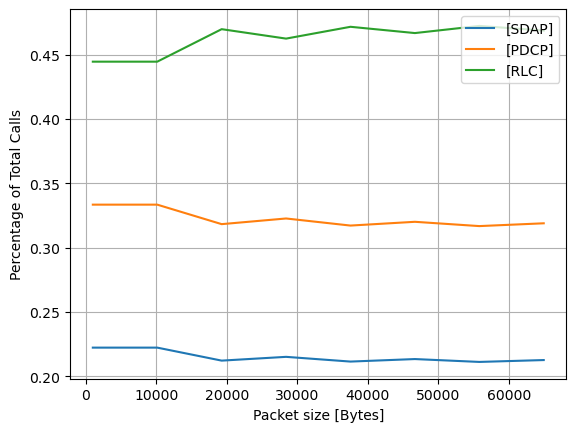

In [5]:
import numpy as np
for module in df["module"].unique():
    plt.plot(sizes, np.array(function_calls[module])/np.array(shapes), label=f"{module}")
plt.grid()
plt.legend()
plt.xlabel("Packet size [Bytes]")
plt.ylabel("Percentage of Total Calls")
plt.savefig("large-packets_ind-function-calls.png")
plt.show()

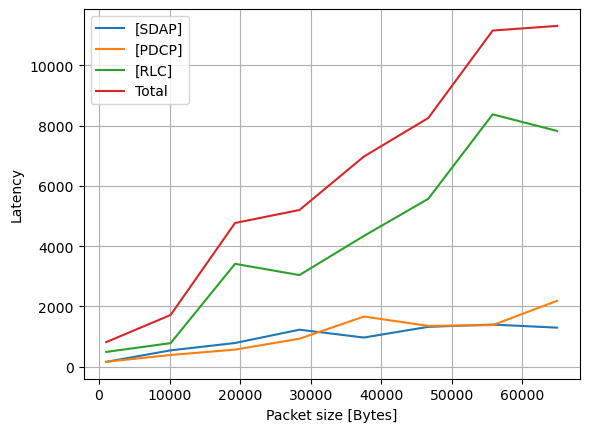

In [6]:
for i in times:
    plt.plot(sizes, times[i], label=f"{i}")
    
plt.plot(sizes, total_times, label="Total")
plt.legend()
plt.grid()
plt.xlabel("Packet size [Bytes]")
plt.ylabel("Latency")
plt.savefig("large-packets_latency-plot.png")
plt.show()

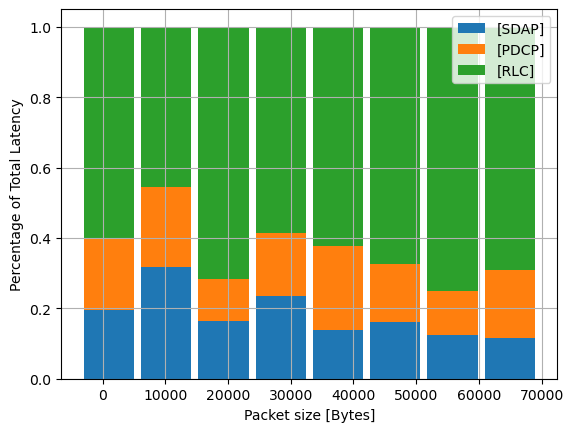

In [7]:
bottom = np.zeros(len(times["[RLC]"]))

for i in times:
    data = np.array(times[i])/np.array(total_times)
    plt.bar(sizes, data, label=f"{i}", width=8000, bottom=bottom, align="center")
    bottom += data
        
plt.legend()
plt.grid()
plt.xlabel("Packet size [Bytes]")
plt.ylabel("Percentage of Total Latency")
plt.savefig("large-packets_latency.png")
plt.show()
